In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os, time
# add the parent directory to the paths
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import UltraCube as UCube

The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


Make an small test region from NGC 1333

In [2]:
from spectral_cube import SpectralCube
if False:
    fpath = "/Users/mcychen/Documents/Data/GAS_NH3/DR1_rebase3/NGC1333/NGC1333_NH3_11_DR1_rebase3_trim.fits"
    ngc1333 = SpectralCube.read(fpath)
    nsmall = ngc1333[:, 210:221, 80:91]
    wpath = "/Users/mcychen/Desktop/UCube_Test/ngc1333_test_cube.fits"
    nsmall.write(wpath, overwrite=True)
    plt.imshow(np.nansum(nsmall._data,axis=0), origin='lower')

Make a small test region from Orion A

In [3]:
fpath = "/Users/mcychen/Documents/Data/GAS_NH3/DR1_rebase3/OrionA_N/OrionA_N_NH3_11_DR1_rebase3_trim.fits"
wpath = "/Users/mcychen/Desktop/UCube_Test/orionA_test_cube.fits"
if False:
    orion = SpectralCube.read(fpath)
    osmall = orion[:, 236:270, 123:145]
    osmall.write(wpath, overwrite=True)
    plt.imshow(np.nansum(osmall._data,axis=0), origin='lower')

Load the cube

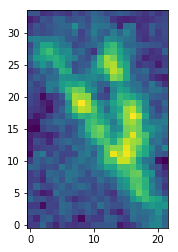

In [4]:
reload(UCube)
orion = UCube.UltraCube(wpath)
plt.imshow(np.nansum(orion.cube._data,axis=0), origin='lower')

Convolve the cube

In [5]:
dirName = "/Users/mcychen/Desktop/UCube_Test/"
cube_cnv_name = "{}/orionA_test_cube_conv2Xbeam.fits".format(dirName)
if False:
    dirName = "/Users/mcychen/Desktop/UCube_Test/"
    #orion.fit_cube(ncomp=[1,2], mask_function=None, snr_min=18)
    cube_cnv_name = "{}/orionA_test_cube_conv2Xbeam.fits".format(dirName)
    #ucube.convolve_sky_byfactor(b59.cube, 2, cube_cnv_name, edgetrim_width=None)
    orion.convolve_cube(factor=2, savename=cube_cnv_name, edgetrim_width=None)

Load, fit, and save the convolved cube

In [6]:
orion_cnv = UCube.UltraCube(cube_cnv_name)
paraDir = '{}/paramaps'.format(dirName)
if False:
    orion_cnv.fit_cube(ncomp=[1,2], snr_min=3)
    UCube.save_model_fit(orion_cnv.pcubes['1'], '{}/orionA_test_para_1vcomp_conv2Xbeam.fits'.format(paraDir), 1)
    UCube.save_model_fit(orion_cnv.pcubes['2'], '{}/orionA_test_para_2vcomp_conv2Xbeam.fits'.format(paraDir), 2)

Load the fitted model

In [7]:
orion_cnv.load_model_fit('{}/orionA_test_para_1vcomp_conv2Xbeam.fits'.format(paraDir), 1)
orion_cnv.load_model_fit('{}/orionA_test_para_2vcomp_conv2Xbeam.fits'.format(paraDir), 2)
mod1 = orion_cnv.pcubes['1'].get_modelcube()
mod2 = orion_cnv.pcubes['2'].get_modelcube()

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,762 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,762 [pyspeckit.spectrum.interactive]


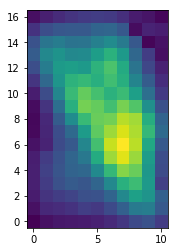

In [8]:
plt.imshow(np.nansum(mod2,axis=0), origin = 'lower')

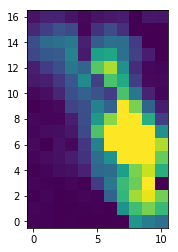

In [9]:
lnk21 = orion_cnv.get_AICc_likelihood(2, 1)
plt.imshow(lnk21, origin="lower", vmin=0, vmax=1000)

In [224]:
p2 = orion_cnv.pcubes['2']
p1 = orion_cnv.pcubes['1']

In [11]:
def show_para(para, figsize=(11, 8)):
    npanel = para.shape[0]
    fig = plt.figure(figsize=figsize)
    
    for i, p in enumerate(para):
        ax = fig.add_subplot(1, npanel, i+1)
        vmin = np.percentile(p[np.isfinite(p)], 1)
        vmax = np.percentile(p[np.isfinite(p)], 99) 
        ax.imshow(p, origin='lower', vmin=vmin, vmax=vmax)

Exame the interpolation

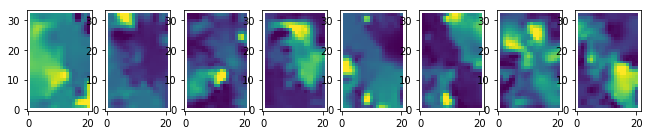

In [243]:
import guess_refine as gf
reload(gf)
data_cnv = np.append(p2.parcube, p2.errcube, axis=0)
guesses_final = gf.guess_from_cnvpara(data_cnv, orion_cnv.cube.header, orion.cube.header)
show_para(guesses_final)

Compare that with the raw fitted results

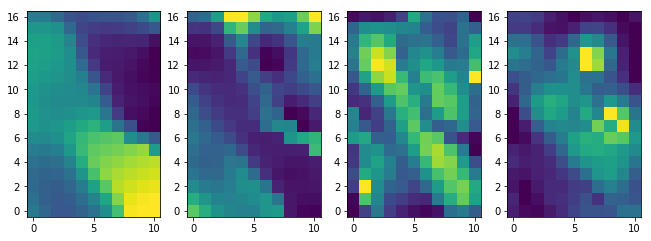

In [247]:
show_para(p1.parcube)

Explore what happen if the parameter maps are quickly sorted

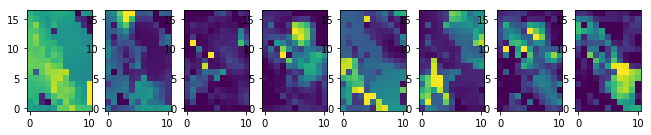

In [266]:
show_para(p2.parcube)
#show_para(p2.errcube)

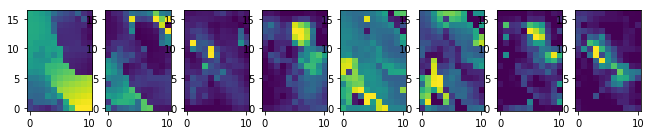

In [277]:
reload(gf)
data_cnv = np.append(p2.parcube, p2.errcube, axis=0)
para_sorted = gf.quick_2comp_sort(data_cnv, filtsize=3, refVMap=p1.parcube[0])
#para_sorted = gf.quick_2comp_sort(data_cnv, filtsize=3)
show_para(para_sorted[0:8])

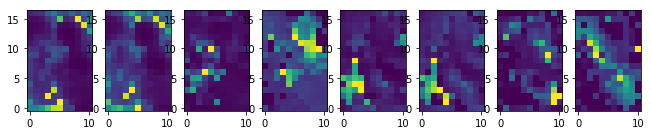

In [268]:
show_para(para_sorted[8:16])

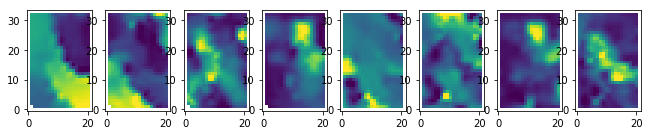

In [274]:
guesses_final = gf.guess_from_cnvpara(para_sorted, orion_cnv.cube.header, orion.cube.header)
show_para(guesses_final)

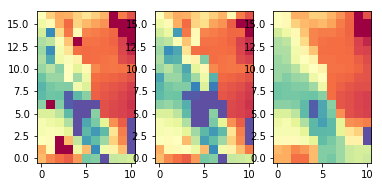

In [179]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax0.imshow(p2.parcube[0], origin='lower', vmin=6.8, vmax=8.3, cmap="Spectral")
ax1.imshow(para_sorted[0], origin='lower', vmin=6.8, vmax=8.3, cmap="Spectral")
ax2 = fig.add_subplot(133)
from scipy.ndimage.filters import median_filter
from skimage.morphology import disk
ax2.imshow(median_filter(p2.parcube[0], footprint=disk(2)), origin='lower', vmin=6.8, vmax=8.3, cmap="Spectral")

fit full resolution using convolved fit results

In [14]:
# elapsed time 91.6 seconds, 741 pixels
if False:
    p1 = orion_cnv.pcubes['1']
    data_cnv = np.append(p1.parcube, p1.errcube, axis=0)
    guesses = gf.guess_from_cnvpara(data_cnv, orion_cnv.cube.header, orion.cube.header)
    orion.fit_cube(ncomp=[1], snr_min=3, guesses = guesses)
    


In [15]:
# Elapsed time was 440.1 seconds
if False:
    p2 = orion_cnv.pcubes['2']
    data_cnv = np.append(p2.parcube, p2.errcube, axis=0)
    guesses = gf.guess_from_cnvpara(data_cnv, orion_cnv.cube.header, orion.cube.header)
    orion.fit_cube(ncomp=[2], snr_min=3, guesses = guesses)

In [16]:
paraDir = '{}/paramaps'.format(dirName)
if False:
    UCube.save_model_fit(orion.pcubes['1'], '{}/orionA_test_para_1vcomp.fits'.format(paraDir), 1)
    UCube.save_model_fit(orion.pcubes['2'], '{}/orionA_test_para_2vcomp.fits'.format(paraDir), 2)

In [17]:
orion.load_model_fit('{}/orionA_test_para_1vcomp.fits'.format(paraDir), 1)
orion.load_model_fit('{}/orionA_test_para_2vcomp.fits'.format(paraDir), 2)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,762 [pyspeckit.spectrum.interactive]


invalid value encountered in greater


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,762 [pyspeckit.spectrum.interactive]


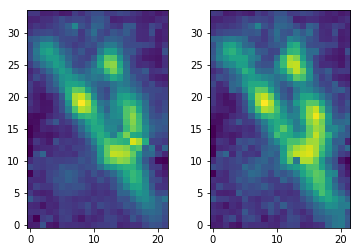

In [215]:
mod1 = orion.pcubes['1'].get_modelcube()
mod2 = orion.pcubes['2'].get_modelcube()
fig = plt.figure()
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax0.imshow(np.nansum(mod1, axis=0), origin='lower')
ax1.imshow(np.nansum(mod2, axis=0), origin='lower')

Use the max residual snr mask instead!

In [21]:
lnk21 = orion.get_AICc_likelihood(2, 1)
mask = lnk21 > 5
modbest = mod1.copy()
modbest[:,mask] = mod2[:,mask]

invalid value encountered in greater


Get the residual of the best model, and their corrosponding rms

In [22]:
modbest[np.isnan(modbest)] = 0
best_res = orion.cube._data - modbest
best_rms = UCube.get_rms(best_res)

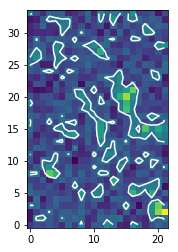

In [23]:
import moment_guess as mmg
reload(mmg)
from spectral_cube import SpectralCube
from astropy import units as u

wdw_wth=4.0

res_cube = SpectralCube(best_res, orion.cube.wcs)
res_cube = res_cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
res_main_hf = mmg.get_window_slab(res_cube, window_hwidth=wdw_wth, v_atpeak=np.nanmedian(orion.pcubes['1'].parcube[0]))

res_main_hf_snr = np.nanmax(res_main_hf, axis=0)/best_rms

plt.imshow(res_main_hf_snr, origin = 'lower')
plt.contour(res_main_hf_snr, [3], colors='1')

Maskout where residual is significant

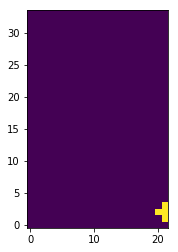

In [26]:
from skimage.morphology import remove_small_objects, disk, opening, erosion, dilation, remove_small_holes
mask_res = res_main_hf_snr > 5
mask_res = dilation(mask_res)
plt.imshow(mask_res, origin='lower')

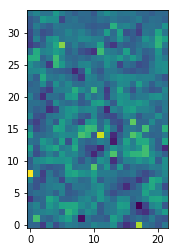

In [27]:
res_main_hf = res_main_hf.with_spectral_unit(u.km/u.s,velocity_convention='radio')
mom0 = res_main_hf.moment0()
plt.imshow(mom0.value/best_rms, origin = 'lower')  

In [28]:
from spectral_cube import SpectralCube

# make sure the cube_res variable does not point to a pre-existing spectral cube
if 'cube_res' in globals():
    del cube_res
cube_res = SpectralCube(data=best_res, wcs=orion.pcubes['2'].wcs.copy(), header=orion.pcubes['2'].header.copy())
cube_res_masked = cube_res.with_mask(~mask_res)

In [29]:
import convolve_tools as cnvtool
reload(cnvtool)
cube_res_cnv = cnvtool.convolve_sky_byfactor(cube_res_masked, factor=2, edgetrim_width=5, snrmasked=False, iterrefine=False)

Assuming position angle has been specified in degrees
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, 

In [30]:
cube_res_cnv = cube_res_cnv.with_spectral_unit(u.km/u.s,velocity_convention='radio')

wdw_wth=3.0
ncomp=1
moms_res_cnv = mmg.window_moments(cube_res_cnv, window_hwidth=wdw_wth,
                                  v_atpeak=np.nanmedian(orion.pcubes['1'].parcube[0]))
gg = mmg.moment_guesses(moms_res_cnv[1], moms_res_cnv[2], ncomp, moment0=moms_res_cnv[0])

invalid value encountered in true_divide
Note that the second moment returned will be a variance map. To get a linewidth map, use the SpectralCube.linewidth_fwhm() or SpectralCube.linewidth_sigma() methods instead.
invalid value encountered in true_divide
invalid value encountered in less
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


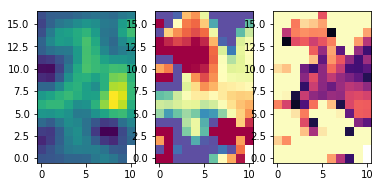

In [31]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
ax0.imshow(moms_res_cnv[0], origin='lower')
ax1 = fig.add_subplot(132)
ax1.imshow(moms_res_cnv[1], origin='lower', vmin=6, vmax=13, cmap='Spectral')
ax2 = fig.add_subplot(133)
ax2.imshow(moms_res_cnv[2], origin='lower', vmin=0, vmax=3, cmap='magma')

36.941315870199396

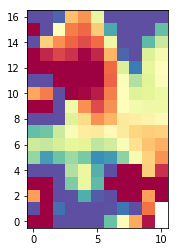

In [32]:
plt.imshow(gg[0], origin='lower', vmin=6, vmax=13, cmap='Spectral')
np.nanmax(gg[0])

In [33]:
orion_cnv_rez = UCube.UltraCube(cube=cube_res_cnv)
orion_cnv_rez.fit_cube(ncomp=[1], snr_min=3, guesses=gg)


number of parameters is 4
the line to fit is oneone
median rms: 0.0249843069524
planemask size: 170, shape: (17, 11)
mask size: 129540, shape: (762, 17, 11)
The median of the user provided velocities is: 9.75467090076
peak T_B: 8.81327582659
v_atpeak: 27.4478378427
user provided guesses accepted
start fit
mask mask!
INFO: Fitting up to 170 spectra [pyspeckit.cubes.SpectralCube]


Invalid value encountered in median for 2 results
invalid value encountered in reduce
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
Mean of empty slice
divide by zero encountered in divide
divide by zero encountered in divide
Using data std() as error.  If signal_cut is set, this can result in some pixels not being fit.


INFO: Fitting    4,   9 (s/n=5) [pyspeckit.cubes.SpectralCube]
INFO: Using input guess cube [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      1 of    170 at (   4,   9) s/n=  5.0. Elapsed time is 0.7 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,762 [pyspeckit.spectrum.interactive]
INFO: Fitting    9,   4 (s/n=5.6) [pyspeckit.cubes.SpectralCube]
INFO: Using input guess cube [pyspeckit.cubes.SpectralCube]
INFO: Fitting   10,   2 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    7,   7 (s/n=5.9) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    7,   8 (s/n=6.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    4,   6 (s/n=4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    4,   0 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    2,   1 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    1,   2 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    3,  11 (s/n=4.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitti

INFO: Finished fit    101 of    170 at (   1,   2) s/n=  3.4. Elapsed time is 2.2 seconds.  %59 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     16 of    170 at (  10,   2) s/n=  3.4. Elapsed time is 2.2 seconds.  %9 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     87 of    170 at (   2,   1) s/n=  3.3. Elapsed time is 2.3 seconds.  %51 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    3,  10 (s/n=4.8) [pyspeckit.cubes.SpectralCube]


INFO: Fitting    7,   5 (s/n=6.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     59 of    170 at (   4,   6) s/n=  4.0. Elapsed time is 2.3 seconds.  %35 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    157 of    170 at (   6,  16) s/n=  3.2. Elapsed time is 2.3 seconds.  %92 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    6,  11 (s/n=6.9) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    5,   8 (s/n=4.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    3,  15 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      1 of    170 at (   9,   4) s/n=  5.6. Elapsed time is 2.7 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     73 of    170 at (   4,   0) s/n=  3.3. Elapsed time is 2.8 seconds.  %43 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    9,   3 (s/n=5.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    6,  10 (s/n=5.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    115 of    170 at (   3,  11) s/n=  4.5. Elapsed time is 3.0 seconds.  %68 [pyspec

INFO: Finished fit      2 of    170 at (   9,   3) s/n=  5.1. Elapsed time is 3.7 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     60 of    170 at (   5,   8) s/n=  4.8. Elapsed time is 3.8 seconds.  %35 [pyspeckit.cubes.SpectralCube]
INFO: Fitting   10,   4 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    5,   0 (s/n=3.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     45 of    170 at (   7,   8) s/n=  6.2. Elapsed time is 4.1 seconds.  %26 [pyspeckit.cubes.SpectralCube]


INFO: Finished fit    103 of    170 at (   1,   1) s/n=  3.3. Elapsed time is 4.2 seconds.  %61 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    158 of    170 at (   3,  15) s/n=  3.8. Elapsed time is 4.2 seconds.  %93 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    7,   0 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    6,  12 (s/n=8.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    5,  16 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    116 of    170 at (   7,  13) s/n=  6.1. Elapsed time is 4.8 seconds.  %68 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    0,   6 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    144 of    170 at (   1,  12) s/n=  6.4. Elapsed time is 5.3 seconds.  %85 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    130 of    170 at (  10,  14) s/n=  3.3. Elapsed time is 5.3 seconds.  %76 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     74 of    170 at (   6,  10) s/n=  5.3. Elapsed time is 5.3 seconds.  %44 [pyspecki

INFO: Fitting    5,   7 (s/n=6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    131 of    170 at (   7,  14) s/n=  4.3. Elapsed time is 5.7 seconds.  %77 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    104 of    170 at (   6,  12) s/n=  8.2. Elapsed time is 5.7 seconds.  %61 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    4,   7 (s/n=4.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    0,   9 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    4,  11 (s/n=4.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      3 of    170 at (  10,   4) s/n=  3.8. Elapsed time is 5.9 seconds.  %2 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    159 of    170 at (   5,  16) s/n=  3.6. Elapsed time is 6.0 seconds.  %94 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,   4 (s/n=6.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    132 of    170 at (   0,   9) s/n=  3.2. Elapsed time is 6.1 seconds.  %78 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    0,  13 (s/n=6.8) [pyspecki

INFO: Finished fit    105 of    170 at (   4,  11) s/n=  4.1. Elapsed time is 6.7 seconds.  %62 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      4 of    170 at (   8,   4) s/n=  6.1. Elapsed time is 6.7 seconds.  %2 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    2,   9 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    9,   5 (s/n=4.9) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    117 of    170 at (   0,   6) s/n=  3.1. Elapsed time is 6.9 seconds.  %69 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    1,   9 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    160 of    170 at (   0,  13) s/n=  6.8. Elapsed time is 7.1 seconds.  %94 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    1,  14 (s/n=6.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     75 of    170 at (   3,   7) s/n=  3.4. Elapsed time is 7.2 seconds.  %44 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     62 of    170 at (   4,   7) s/n=  4.5. Elapsed time is 7.3 seconds.  %36 [pyspeckit

INFO: Finished fit    108 of    170 at (   1,   0) s/n=  3.1. Elapsed time is 10.0 seconds.  %64 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     63 of    170 at (   6,   9) s/n=  4.8. Elapsed time is 10.0 seconds.  %37 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    1,   8 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    3,   4 (s/n=3.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     89 of    170 at (   2,   7) s/n=  3.1. Elapsed time is 10.3 seconds.  %52 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    162 of    170 at (   4,  16) s/n=  3.3. Elapsed time is 10.4 seconds.  %95 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    3,   9 (s/n=5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     33 of    170 at (   9,   8) s/n=  6.1. Elapsed time is 10.4 seconds.  %19 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    2,  15 (s/n=4.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    5,   4 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     19 of    170 a

INFO: Finished fit    165 of    170 at (   0,  14) s/n=  5.6. Elapsed time is 15.5 seconds.  %97 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    137 of    170 at (   5,  14) s/n=  4.3. Elapsed time is 15.5 seconds.  %81 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    1,  15 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    0,  10 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     92 of    170 at (   9,  12) s/n=  4.3. Elapsed time is 15.8 seconds.  %54 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,  12 (s/n=4.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    112 of    170 at (   8,  13) s/n=  4.0. Elapsed time is 15.9 seconds.  %66 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     35 of    170 at (   9,   0) s/n=  3.1. Elapsed time is 16.0 seconds.  %21 [pyspeckit.cubes.SpectralCube]
INFO: Fitting   10,  13 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    5,   3 (s/n=3.5) [pyspeckit.cubes.SpectralCube]


INFO: Finished fit     22 of    170 at (   9,   1) s/n=  3.3. Elapsed time is 16.1 seconds.  %13 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    150 of    170 at (   9,  16) s/n=  3.1. Elapsed time is 16.1 seconds.  %88 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    9,   7 (s/n=6.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,  16 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     80 of    170 at (   4,   9) s/n=  5.0. Elapsed time is 16.2 seconds.  %47 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,  11 (s/n=4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     67 of    170 at (  10,  10) s/n=  3.5. Elapsed time is 16.4 seconds.  %39 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,  10 (s/n=4.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      8 of    170 at (  10,   3) s/n=  3.6. Elapsed time is 16.6 seconds.  %5 [pyspeckit.cubes.SpectralCube]


INFO: Finished fit    151 of    170 at (   8,  16) s/n=  3.2. Elapsed time is 16.6 seconds.  %89 [pyspeckit.cubes.SpectralCube]
INFO: Fitting   10,   5 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting   10,  16 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     52 of    170 at (   5,   1) s/n=  3.2. Elapsed time is 16.7 seconds.  %31 [pyspeckit.cubes.SpectralCube]
INFO: Fitting   10,   9 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    113 of    170 at (  10,  13) s/n=  3.1. Elapsed time is 16.9 seconds.  %66 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    138 of    170 at (   0,  10) s/n=  3.1. Elapsed time is 16.9 seconds.  %81 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    2,  10 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    3,  13 (s/n=5.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    166 of    170 at (   1,  15) s/n=  4.2. Elapsed time is 17.1 seconds.  %98 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    2,  16 (s/n=3.6) [py

INFO: Finished fit    140 of    170 at (   9,  15) s/n=  2.9. Elapsed time is 19.0 seconds.  %82 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     53 of    170 at (  10,   9) s/n=  3.3. Elapsed time is 19.0 seconds.  %31 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    114 of    170 at (   2,  10) s/n=  4.2. Elapsed time is 19.1 seconds.  %67 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,  15 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,   9 (s/n=6.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     82 of    170 at (   5,  10) s/n=  4.6. Elapsed time is 19.1 seconds.  %48 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    3,   0 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      9 of    170 at (  10,   5) s/n=  3.3. Elapsed time is 19.5 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    9,   6 (s/n=4.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     69 of    170 at (   3,   6) s/n=  3.6. Elapsed time is 19.6 seconds.  %41 [pyspe

INFO: Finished fit    141 of    170 at (   8,  15) s/n=  3.4. Elapsed time is 19.8 seconds.  %83 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     23 of    170 at (   9,   7) s/n=  6.3. Elapsed time is 19.8 seconds.  %14 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    7,  15 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    6,   3 (s/n=4.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    124 of    170 at (   0,   8) s/n=  3.2. Elapsed time is 20.1 seconds.  %73 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    152 of    170 at (  10,  16) s/n=  3.0. Elapsed time is 20.2 seconds.  %89 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     54 of    170 at (   8,   9) s/n=  6.1. Elapsed time is 20.2 seconds.  %32 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    2,  11 (s/n=4.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    0,  12 (s/n=5.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    4,   5 (s/n=3.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     94 of    170

INFO: Finished fit     24 of    170 at (   6,   3) s/n=  4.5. Elapsed time is 20.7 seconds.  %14 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,   1 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     70 of    170 at (   7,  10) s/n=  5.7. Elapsed time is 20.8 seconds.  %41 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     83 of    170 at (   3,   0) s/n=  3.0. Elapsed time is 20.8 seconds.  %49 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    5,   9 (s/n=4.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    3,   8 (s/n=4.7) [pyspeckit.cubes.SpectralCube]


INFO: Finished fit    142 of    170 at (   7,  15) s/n=  3.2. Elapsed time is 21.0 seconds.  %84 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    169 of    170 at (   1,  16) s/n=  3.1. Elapsed time is 21.3 seconds.  %99 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     55 of    170 at (   4,   5) s/n=  3.5. Elapsed time is 21.4 seconds.  %32 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    0,  16 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    4,   3 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    125 of    170 at (   2,  11) s/n=  4.7. Elapsed time is 21.7 seconds.  %74 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    9,  14 (s/n=3) [pyspeckit.cubes.SpectralCube]


INFO: Finished fit    170 of    170 at (   0,  16) s/n=  3.2. Elapsed time is 22.0 seconds.  %100 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     71 of    170 at (   5,   9) s/n=  4.8. Elapsed time is 22.0 seconds.  %42 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    4,   8 (s/n=4.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    153 of    170 at (   0,  12) s/n=  5.7. Elapsed time is 22.1 seconds.  %90 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    1,  13 (s/n=7.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     25 of    170 at (   8,   1) s/n=  3.2. Elapsed time is 22.3 seconds.  %15 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     95 of    170 at (   2,   8) s/n=  3.3. Elapsed time is 22.3 seconds.  %56 [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     38 of    170 at (  10,   8) s/n=  3.4. Elapsed time is 22.3 seconds.  %22 [pyspeckit.cubes.SpectralCube]
INFO: Fitting    8,   7 (s/n=7.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting    5,  11 (s/n=5.8) [p

invalid value encountered in greater


plot the residual model

All-NaN slice encountered


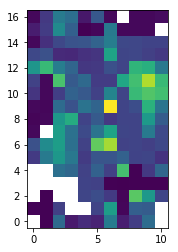

In [34]:
rez_mod_cnv_1 = orion_cnv_rez.pcubes['1'].get_modelcube()
plt.imshow(np.nanmax(rez_mod_cnv_1, axis=0), origin='lower')

In [35]:
rez_par_cnv_1 = orion_cnv_rez.pcubes['1'].parcube

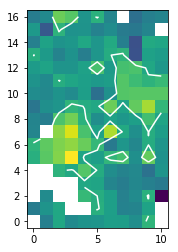

In [36]:
plt.imshow(orion_cnv_rez.get_AICc_likelihood(1,0), origin='lower')
plt.contour(orion_cnv_rez.get_AICc_likelihood(1,0), [5], colors='1')

invalid value encountered in greater


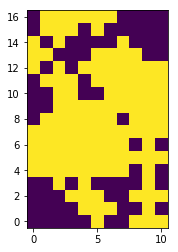

In [37]:
aic1v0_mask = orion_cnv_rez.get_AICc_likelihood(1,0) > 5
aic1v0_mask_dil = dilation(aic1v0_mask)
plt.imshow(aic1v0_mask_dil, origin='lower')

13.75467090076277 0.0


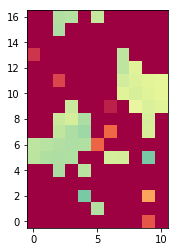

In [38]:
plt.imshow(rez_par_cnv_1[0]*aic1v0_mask, origin='lower', vmin=6, vmax=13, cmap='Spectral')
print np.nanmax(rez_par_cnv_1[0]), np.nanmin(rez_par_cnv_1[0])

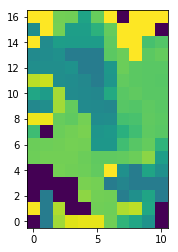

In [39]:
plt.imshow(rez_par_cnv_1[0], origin='lower')

In [42]:
hdr2D = cnvtool.get_celestial_hdr(orion.cube.header)
hdr2D_cnv = cnvtool.get_celestial_hdr(orion_cnv.cube.header)

5.5458965436628835 7.330033237617048 8.86769218792023


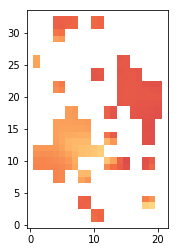

In [43]:
ff_mask = cnvtool.regrid_mask(aic1v0_mask, hdr2D_cnv, hdr2D, tightBin=False)
#ff_mask = cnvtool.regrid_mask(aic1v0_mask_dil, hdr2D_cnv, hdr2D, tightBin=False) 
#plt.imshow(ff_mask,origin='lower')
funk = ff_mask.copy()
funk = funk.astype(float)
funk[funk == 0] = np.nan
plt.imshow(guesses_final[0]*funk, origin='lower', vmin=6, vmax=13, cmap='Spectral')


print np.nanmin(guesses_final[0]),np.nanmedian(guesses_final[0]), np.nanmax(guesses_final[0])

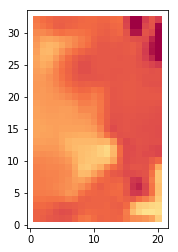

In [44]:
plt.imshow(guesses_final[0], origin='lower', vmin=6, vmax=13, cmap='Spectral')

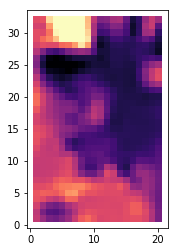

In [45]:
plt.imshow(guesses_final[1], origin='lower', vmin=0, vmax=1, cmap='magma')

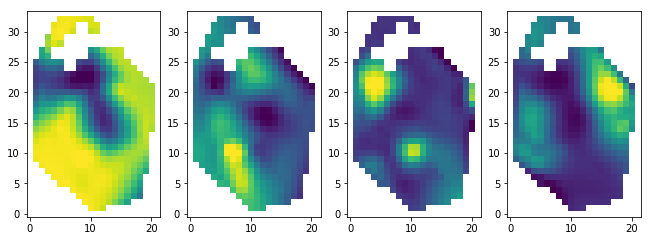

In [46]:
reload(gf)
data_cnv = np.append(orion_cnv_rez.pcubes['1'].parcube, orion_cnv_rez.pcubes['1'].errcube, axis=0)
preguess = data_cnv.copy()
preguess[:,~aic1v0_mask] = np.nan
#preguess[:,~aic1v0_mask_dil] = np.nan



guesses_final = gf.guess_from_cnvpara(preguess, orion_cnv.cube.header, orion.cube.header, mask=aic1v0_mask_dil)
show_para(guesses_final)

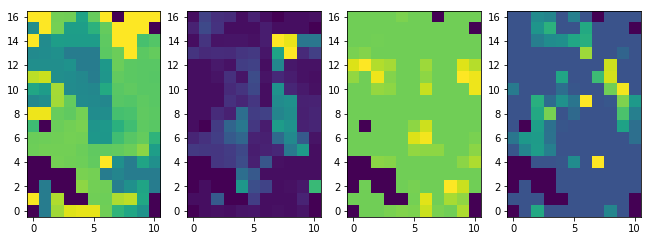

In [47]:
show_para(orion_cnv_rez.pcubes['1'].parcube)

In [48]:
np.nanmax(rez_par_cnv_1[0])

13.75467090076277

7.812932810688073

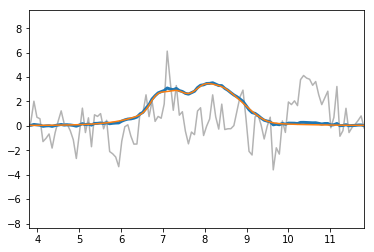

In [49]:
cube_res_cnv = cube_res_cnv.with_spectral_unit(u.km/u.s,velocity_convention='radio')
plt.plot(cube_res_cnv.spectral_axis, np.nansum(cube_res_cnv._data, axis=(1,2)), c='0.7')
plt.plot(cube_res_cnv.spectral_axis, np.nansum(orion.cube._data, axis=(1,2))/100, linewidth=3)
plt.plot(cube_res_cnv.spectral_axis, np.nansum(modbest, axis=(1,2))/100)

voff_wind = 4
plt.xlim((7.8-voff_wind, 7.8+voff_wind))
np.nanmedian(orion.pcubes['1'].parcube[0])

7.812932810688073

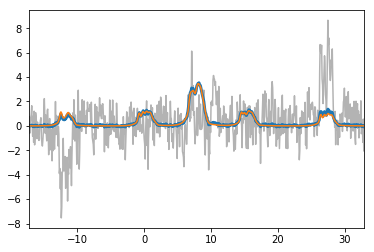

In [74]:
cube_res_cnv = cube_res_cnv.with_spectral_unit(u.km/u.s,velocity_convention='radio')
plt.plot(cube_res_cnv.spectral_axis, np.nansum(cube_res_cnv._data, axis=(1,2)), c='0.7')
plt.plot(cube_res_cnv.spectral_axis, np.nansum(orion.cube._data, axis=(1,2))/100, linewidth=3)
plt.plot(cube_res_cnv.spectral_axis, np.nansum(modbest, axis=(1,2))/100)

voff_wind = 25
plt.xlim((7.8-voff_wind, 7.8+voff_wind))
np.nanmedian(orion.pcubes['1'].parcube[0])

A quick demonstration that moment estimate is not good to check the residual as well, compared to peak SNR of the residual.

In [50]:
pp1=orion_cnv_rez.pcubes['1']
pp1mod = pp1.get_modelcube()

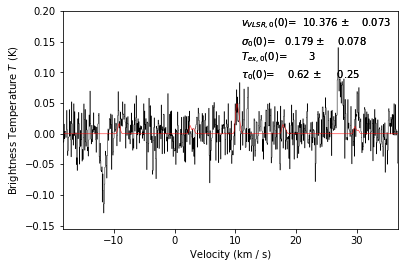

In [51]:
#pp1.plotter()
yyy = 8
pp1.plot_spectrum(3,yyy)
pp1.plot_fit(3,yyy)

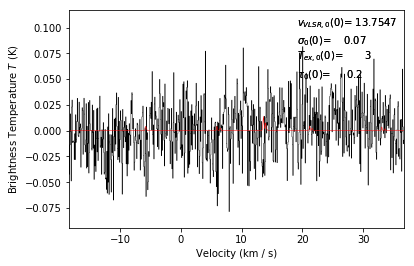

In [52]:
pp1.plot_spectrum(7,15)
pp1.plot_fit(7,15)

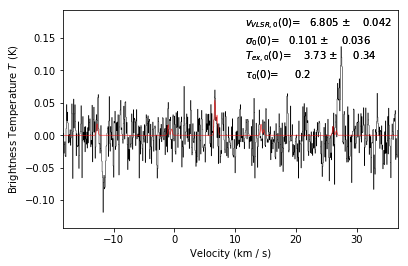

In [53]:
pp1.plot_spectrum(2,11)
pp1.plot_fit(2,11)

invalid value encountered in less


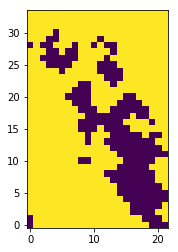

In [54]:
#orion.pcubes['1'].parcube.shape
fff_guesses = np.append(orion.pcubes['1'].parcube, guesses_final, axis=0)
lnk21 = orion.get_AICc_likelihood(2, 1)
fff_mask = lnk21<5
fff_mask = dilation(fff_mask)
plt.imshow(fff_mask, origin="lower")

invalid value encountered in greater


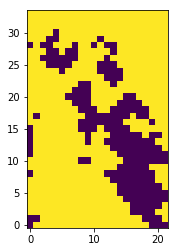

In [55]:
lnk10 = orion.get_AICc_likelihood(1, 0)
fff_mask = np.logical_and(fff_mask, lnk10>5)
plt.imshow(fff_mask, origin="lower")

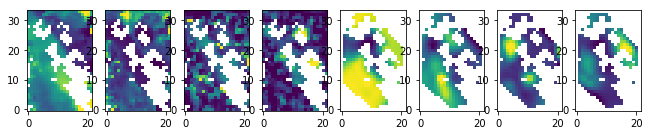

In [56]:
ffunk = fff_mask.astype(float)
ffunk[~fff_mask] = np.nan
show_para(fff_guesses*ffunk)


Try fitting two components again (361.4 seconds)

In [57]:
if 'orion_new' in globals():
    del orion_new

orion_new = UCube.UltraCube(wpath)
if False:
    orion_new.fit_cube(ncomp=[2], maskmap=fff_mask, snr_min=3, guesses=fff_guesses)
    UCube.save_model_fit(orion_new.pcubes['2'], '{}/orionA_test_para_2vcomp_wideRcvy.fits'.format(paraDir), 2)
else:
    orion_new.load_model_fit('{}/orionA_test_para_2vcomp_wideRcvy.fits'.format(paraDir), 2)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,762 [pyspeckit.spectrum.interactive]


All-NaN slice encountered
All-NaN slice encountered


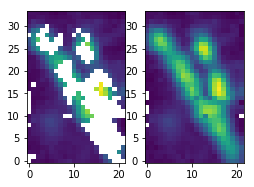

In [58]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
ax0.imshow(np.nanmax(orion_new.pcubes['2'].get_modelcube(), axis=0), origin="lower")
ax1 = fig.add_subplot(132)
ax1.imshow(np.nanmax(orion.pcubes['2'].get_modelcube(), axis=0), origin="lower")

#plt.imshow(np.nanmax(orion_new.pcubes['2'].get_modelcube(), axis=0), origin='lower')

In [59]:
lnk_NvsO = UCube.calc_AICc_likelihood(orion_new, 2, 2, ucube_B=orion)

invalid value encountered in greater


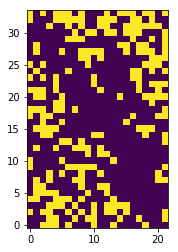

In [60]:
plt.imshow(lnk_NvsO>0, origin='lower')
#plt.imshow(lnk_NvsO, origin='lower', vmin=-5, vmax=5, cmap='Spectral')

In [61]:
if 'orion_final' in globals():
    del orion_final
orion_final = UCube.UltraCube(wpath)
#orion_final.load_model_fit('{}/orionA_test_para_1vcomp.fits'.format(paraDir), 1)
#orion_final.load_model_fit('{}/orionA_test_para_2vcomp.fits'.format(paraDir), 2)
#orion_final.pcubes['1'] = orion.pcubes['1'].copy()
#orion_final.pcubes['2'] = orion.pcubes['2'].copy()

In [62]:
pcube_final_2 = orion.pcubes['2'].copy('deep')

In [63]:
def replace_para(pcube, pcube_ref, mask):
    pcube.parcube[:,mask] = pcube_ref.parcube[:,mask]
    pcube.errcube[:,mask] = pcube_ref.errcube[:,mask]

invalid value encountered in greater
invalid value encountered in less


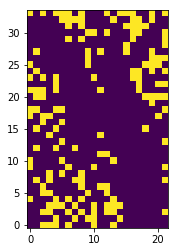

In [64]:
#replace_para(orion_final.pcubes['2'], orion_new.pcubes['2'], lnk_NvsO>5)
# mask over where one comp fit is more robust
good_mask = np.logical_and(lnk_NvsO>0, lnk21<5)
plt.imshow(good_mask, origin='lower')

In [65]:
replace_para(pcube_final_2, orion_new.pcubes['2'], good_mask)

In [66]:
UCube.save_model_fit(pcube_final_2, '{}/orionA_test_para_2vcomp_final.fits'.format(paraDir), 2)
orion_final.load_model_fit('{}/orionA_test_para_1vcomp.fits'.format(paraDir), 1)
orion_final.load_model_fit('{}/orionA_test_para_2vcomp_final.fits'.format(paraDir), 2)

parameter cube saved!
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,762 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,762 [pyspeckit.spectrum.interactive]


In [67]:
#fffmod2 = orion_final.pcubes['2'].get_modelcube(update=True)

In [68]:
#plt.imshow(np.nanmax(fffmod2, axis=0), origin='lower')

In [69]:
lnk21_ff = orion_final.get_AICc_likelihood(2, 1)

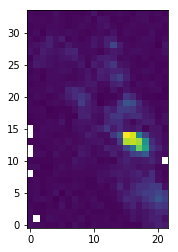

In [70]:
plt.imshow(lnk21_ff, origin='lower')

invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in greater


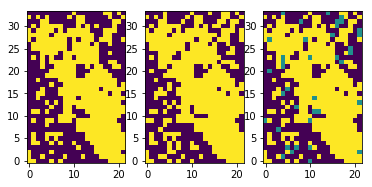

In [71]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
ax0.imshow(lnk21>5, origin="lower")
ax1 = fig.add_subplot(132)
ax1.imshow(lnk21_ff>5, origin="lower")
ax2 = fig.add_subplot(133)
ax2.imshow((lnk21_ff>5)*1.0 + (lnk21>5)*1.0, origin="lower")

In [75]:
pp2=orion_final.pcubes['2']
pp2mod = pp2.get_modelcube()

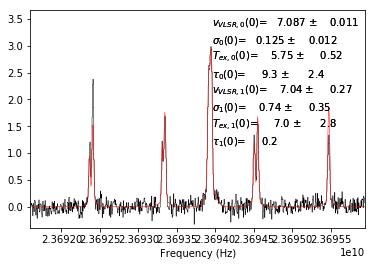

In [86]:
pp2.plot_spectrum(13,25)
pp2.plot_fit(13,25)

In [87]:
res = orion_final.get_residual(2)

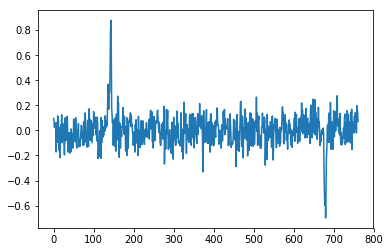

In [88]:
plt.plot(res[:,25,13])